In [1]:
import pandas as pd
import pickle

In [2]:
Fed_df = pd.read_pickle('/Users/georgii_nigm/Applications/VS Code projects/academic_causal_portfolio/cleaned/fedfunds.pickle')

In [3]:
Fed_df

observation_date
1954-07-01    0.80
1954-08-01    1.22
1954-09-01    1.07
1954-10-01    0.85
1954-11-01    0.83
              ... 
2023-02-01    4.57
2023-03-01    4.65
2023-04-01    4.83
2023-05-01    5.06
2023-06-01    5.08
Name: FEDFUNDS_20230703, Length: 828, dtype: float64

In [4]:
type(Fed_df)

pandas.core.series.Series

In [5]:
import yfinance as yf

# Define the tickers
banks_and_financial_institutions = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS']
real_estate = ['SPG', 'AMT', 'PLD', 'EQR', 'PSA', 'WELL']
utilities = ['NEE', 'DUK', 'D', 'SO', 'EXC', 'AEP']

# Combine all tickers into a single list
all_tickers = banks_and_financial_institutions + real_estate + utilities

# Define a function to download the data
def download_data(tickers, start_date='1990-01-01', end_date='2021-12-31'):
    data = {}
    for ticker in tickers:
        stock_data = yf.Ticker(ticker)
        data[ticker] = stock_data.history(period='1d', start=start_date, end=end_date)
    return data

# Download the data for the specified tickers
stock_data = download_data(all_tickers)


# Example to print the data for JPMorgan Chase & Co.
print(stock_data['JPM'])


                                 Open        High         Low       Close  \
Date                                                                        
1990-01-02 00:00:00-05:00    3.380324    3.408612    3.380324    3.394468   
1990-01-03 00:00:00-05:00    3.436899    3.507617    3.394468    3.507617   
1990-01-04 00:00:00-05:00    3.507615    3.535902    3.493471    3.521759   
1990-01-05 00:00:00-05:00    3.535903    3.535903    3.479328    3.535903   
1990-01-08 00:00:00-05:00    3.521759    3.550046    3.493472    3.535903   
...                               ...         ...         ...         ...   
2021-12-23 00:00:00-05:00  149.459775  150.891686  149.080466  149.127869   
2021-12-27 00:00:00-05:00  149.450314  150.019279  148.255461  149.981354   
2021-12-28 00:00:00-05:00  150.019274  151.868434  149.905484  150.436523   
2021-12-29 00:00:00-05:00  150.635669  151.375333  149.971855  150.360657   
2021-12-30 00:00:00-05:00  150.882217  151.953787  150.180478  150.284790   

In [6]:
# stock_data['JPM'].index

# formatted_date = date_object.strftime("%Y-%m-%d")

In [7]:
close_prices = pd.DataFrame()
for x in all_tickers:
    close_prices[x] = stock_data[x]['Close']
close_prices.index = close_prices.index.strftime('%Y-%m-%d')

In [8]:
close_prices = close_prices.join(Fed_df)
close_prices['FEDFUNDS_20230703'].fillna(method='ffill', inplace=True)
close_prices.fillna(method='bfill', inplace=True)

In [9]:
close_prices = close_prices[close_prices.index >= '1990-02-01']

In [10]:
close_prices_crop = close_prices.iloc[:,10:]

In [11]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI

(<Figure size 640x480 with 9 Axes>,
 array([<Axes: ylabel='PSA'>, <Axes: ylabel='WELL'>, <Axes: ylabel='NEE'>,
        <Axes: ylabel='DUK'>, <Axes: ylabel='D'>, <Axes: ylabel='SO'>,
        <Axes: ylabel='EXC'>, <Axes: ylabel='AEP'>,
        <Axes: ylabel='FEDFUNDS_20230703'>], dtype=object))

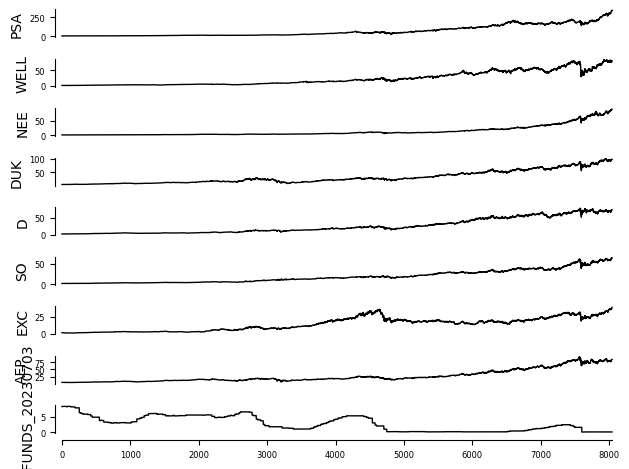

In [12]:
var_names=close_prices_crop.columns
dataframe = pp.DataFrame(close_prices_crop.values, var_names=var_names)
tp.plot_timeseries(dataframe)

In [13]:
# Init
parcorr = ParCorr(significance='analytic')

pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr)

In [14]:
tau_max = 4

In [15]:
results = pcmci_parcorr.run_pcmci(tau_max=tau_max,  pc_alpha=None, alpha_level=0.001)


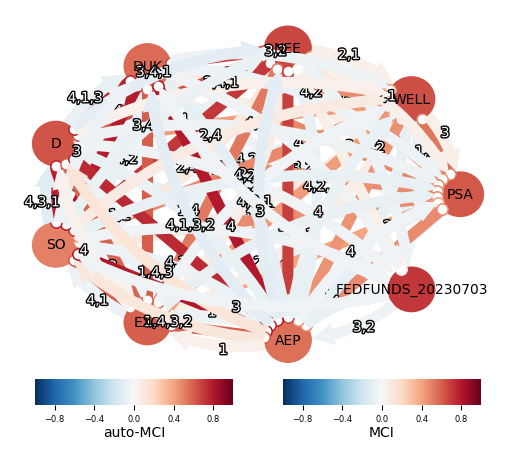

In [16]:
tp.plot_graph(results['graph'], val_matrix=results['val_matrix'], var_names=var_names)
plt.show()

In [21]:
q_matrix = pcmci_parcorr.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
# pcmci_parcorr.print_significant_links(
#         p_matrix = q_matrix,
#         val_matrix = results['val_matrix'],
#         alpha_level = 0.01)
graph = pcmci_parcorr.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=0.05, 
            tau_min=0, tau_max=tau_max, link_assumptions=None)
results['graph'] = graph

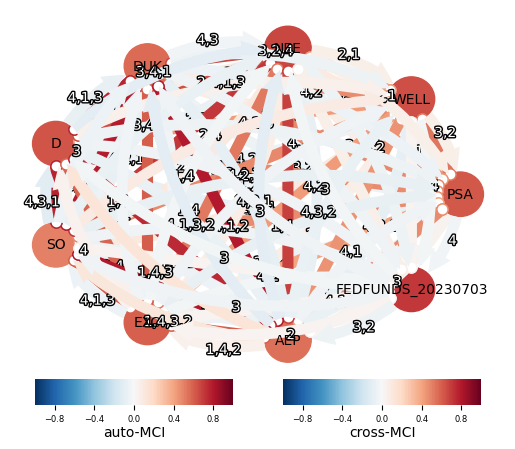

In [22]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()